<a href="https://colab.research.google.com/github/AnnaKholkina/rl_guu/blob/main/new_ver_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
#from tensorboardX import SummaryWriter
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 50

import warnings
import operator
import random
warnings.filterwarnings("ignore")

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size=128, out_size1=4, out_size2=2):
        super(SimpleNet, self).__init__()
        self.linear_common = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU() 
        )
        self.linear1 = nn.Sequential(
            nn.Linear(hidden_size, out_size1),
            nn.ReLU() 
        )

        self.linear2 = nn.Sequential(
            nn.Linear(hidden_size, out_size2),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.linear_common(x)
        return self.linear1(x), self.linear2(x)

In [ ]:
class Episode:
    def __init__(self):
        self.total_reward = 0
        self.observations = []
        self.actions = []

### Задача

Для начала я решила попробовать решить простую задачу: имеется один поставщик, у которого есть 80 единиц продукции (изначально они равномерно распределены между заказчиками, массив trans) и 4 заказчика (customers). Массив цен, по которым поставщик продает каждому заказчику называется costs. Задача поставщика распределить товары таким образом, чтобы получить от этого максимальную прибыль.

В дальнейшем эту задачу можно инвертировать и привести к задаче минимизации затрат на транспортировку, но пока что я решила решать максимизацию, которая заложена в классической постановке задачи обучения с подкреплением.

In [ ]:
customers = np.array([75, 80, 60, 85])
trans = np.array([20, 20, 20, 20])
costs = np.array([6, 7, 3, 5])

In [ ]:
trans * costs

array([120, 140,  60, 100])

In [ ]:
np.sum(trans * costs)

420

In [ ]:
net = SimpleNet(input_size=4)
x = torch.tensor(trans, dtype=torch.float)
ind, act = net(x)

In [ ]:
ind

tensor([0.0000, 3.4178, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

In [ ]:
act

tensor([3.3498, 0.0000], grad_fn=<ReluBackward0>)

### Как работает нейросеть

На вход она получает массив текущего состояния стоимости продажи продукции (trans * costs). Мне показалось это более разумно, так нейросеть будет понимать сколько мы зарабатываем, а не просто непонятные числа из trans (изначально в экспериментах я давала ей просто trans, как в этом маленьком примере, но ничего хорошего из этого не вышло). На выходе мы имеем массив той же размерности, по аргмаксу которого определяется индекс, элемент которого мы будем менять. Я немного модифицировала Вашу нейросеть и подавала на linear2 слой linear1. Как бы из информации о том, какой элемент будет изменяться, принимать решение прибавлять к нему 1 или убавлять.

К слову, были также эксперименты с Вашей архитектурой, тоже провалились.

In [ ]:
ind

tensor([4.7994, 0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

In [ ]:
act

tensor([1.7350, 1.7502], grad_fn=<ReluBackward0>)

In [ ]:
torch.argmax(ind)

tensor(1)

### Как делается шаг

Первый атпут нейросети выдает позицию, с которой нужно произвести действие. Второй атпут определяет какое действие - убавить на 1 или прибавить на 1. Также я попробовала ввести ограничения транспортной задачи, поэтому при увеличении одного элемента, другой рандомный уменьшается и наоборот.

In [ ]:
def step(t, position, action, limit=200):
  random_pos_list = [0, 1, 2, 3]
  random_pos_list.remove(position)
  random_el = random.choice(random_pos_list)
  if action == 0 and t[position] > 0 and t[position] <= customers[position] and torch.sum(t) <= limit:
  #if action == 0:
    t[position] -= 1
    t[random_el] += 1
  if action == 1 and t[position] <= customers[position] and t[random_el] > 0 and torch.sum(t) <= limit:
  #if action == 1:
    t[position] += 1
    t[random_el] -= 1

  return torch.tensor(t, dtype=torch.float)

In [ ]:
def reward(trans, costs):
  assert trans.shape == costs.shape, 'Проверить размерности таблиц'

  reward = 0
  for i in range(len(trans)):
      reward += trans[i]*costs[i]
  
  return reward

In [ ]:
def episode_batch_generator(table, model, batch_size, num_episodes, show_prints=False):
  episodes = []
  start_obs = torch.tensor(table, dtype=torch.float)
  obs = start_obs.clone().detach() # копирую изначальное состояние
  episode = Episode()
  softmax = nn.Softmax()

  for ep in range(num_episodes): # я не придумала, как сделать подобие done в картполе, поэтому просто генерирую несколько эпизодов с длиной батча
    for itr in range(batch_size):
      costs_obs = torch.tensor(obs * costs, dtype=torch.float)
      indexes_val, actions_val = model(costs_obs)

      indexes_prob = softmax(indexes_val)
      indexes_prob = indexes_prob.data.numpy()
      index = np.random.choice(4, p=indexes_prob) # выбираю индекс, элемент которого будет изменен

      actions_prob = softmax(actions_val)
      actions_prob = actions_prob.data.numpy()
      action = np.random.choice(2, p=actions_prob) # выбираю действие

      next_obs = step(obs, index, action)
      r = reward(next_obs, costs)
      if show_prints:
        print(f'Itr: {itr}')
        print(f'Index: {index}, action: {action}')
        print(next_obs)
        print(r)

      episode.total_reward += r
      episode.observations.append(obs)
      episode.actions.append(action)
      obs = next_obs

    episodes.append(episode)
    if show_prints:
      print(f'Results of episode: total_reward - {episode.total_reward}')
    episode = Episode()
    obs = start_obs.clone().detach()
    if show_prints:
      print(f'End episode {ep}, start_obs = {obs}')
  
  return episodes

В этой функции не учитываются индексы, но ниже есть вторая реализация, где помимо действия сравниваются еще и индексы.

In [ ]:
def filter_elite_episodes(batch, min_reward_percentice):
    actions, observations = [], []
    rewards = list(map(lambda e: e.total_reward, batch))
    reward_boundary = np.percentile(rewards, min_reward_percentice)
    for episode in batch:
        if episode.total_reward < reward_boundary:
          continue

        observations.extend(episode.observations)
        actions.extend(episode.actions)
    mean_rewards = np.mean(rewards)

    return torch.stack(observations), torch.FloatTensor(actions), mean_rewards

In [ ]:
b = episode_batch_generator(trans, net, 16, 1, show_prints=True)

Itr: 0
Index: 1, action: 0
tensor([20., 19., 21., 20.])
tensor(416.)
Itr: 1
Index: 1, action: 0
tensor([20., 18., 22., 20.])
tensor(412.)
Itr: 2
Index: 1, action: 0
tensor([20., 17., 22., 21.])
tensor(410.)
Itr: 3
Index: 1, action: 0
tensor([20., 16., 22., 22.])
tensor(408.)
Itr: 4
Index: 1, action: 0
tensor([20., 15., 22., 23.])
tensor(406.)
Itr: 5
Index: 1, action: 0
tensor([21., 14., 22., 23.])
tensor(405.)
Itr: 6
Index: 1, action: 0
tensor([22., 13., 22., 23.])
tensor(404.)
Itr: 7
Index: 1, action: 0
tensor([22., 12., 22., 24.])
tensor(402.)
Itr: 8
Index: 1, action: 0
tensor([23., 11., 22., 24.])
tensor(401.)
Itr: 9
Index: 1, action: 0
tensor([23., 10., 23., 24.])
tensor(397.)
Itr: 10
Index: 1, action: 0
tensor([24.,  9., 23., 24.])
tensor(396.)
Itr: 11
Index: 1, action: 0
tensor([24.,  8., 23., 25.])
tensor(394.)
Itr: 12
Index: 1, action: 0
tensor([24.,  7., 23., 26.])
tensor(392.)
Itr: 13
Index: 1, action: 0
tensor([25.,  6., 23., 26.])
tensor(391.)
Itr: 14
Index: 1, action: 1
te

In [ ]:
filter_elite_episodes(b, 90)

(tensor([[20., 19., 21., 20.],
         [20., 18., 22., 20.],
         [20., 17., 22., 21.],
         [20., 16., 22., 22.],
         [20., 15., 22., 23.],
         [21., 14., 22., 23.],
         [22., 13., 22., 23.],
         [22., 12., 22., 24.],
         [23., 11., 22., 24.],
         [23., 10., 23., 24.],
         [24.,  9., 23., 24.],
         [24.,  8., 23., 25.],
         [24.,  7., 23., 26.],
         [25.,  6., 23., 26.],
         [24.,  7., 23., 26.],
         [25.,  6., 23., 26.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 6417.0)

In [ ]:
def train(table, batch_size, num_episodes):
  model = SimpleNet(input_size=4)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  loss_fn = nn.CrossEntropyLoss()
  softmax = nn.Softmax(dim=1)
  losses = []
  for iter in range(100):
    b = episode_batch_generator(table, model, batch_size, num_episodes)
    observations, target_actions, mean_rewards = filter_elite_episodes(b, 90)
    optimizer.zero_grad()
    indexes_val, actions_val = model(observations)
    index = torch.argmax(indexes_val, dim=1, keepdim=False)
    pred_actions = torch.argmax(actions_val, dim=1, keepdim=False)
    loss = loss_fn(torch.tensor(pred_actions, dtype=torch.float, requires_grad=True), target_actions)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'\rItr:{iter}, loss :{loss}, mean reward: {mean_rewards}', end='')

  return losses

In [ ]:
losses = train(trans, 10, 10)

Itr:99, loss :23.025854110717773, mean reward: 4025.89990234375

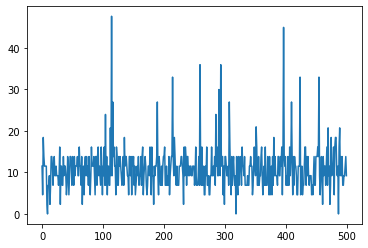

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

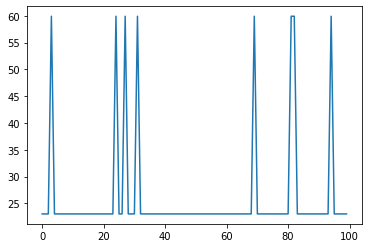

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

### Это был, наверное, уже сотый эксперимент, но лосс никогда не вел себя как нужно. В некоторых случаях достигался хороший reward, но это была рандомная перестановка до тех пор, пока не достигнется нужное значение.

### 2 подход. Смотрим и на индекс, и на действие

In [ ]:
class Episode:
    def __init__(self):
        self.total_reward = 0
        self.observations = []
        self.actions = []
        self.indexes = []

In [ ]:
def episode_batch_generator(table, model, batch_size, num_episodes, show_prints=False):
  batch = []
  start_obs = torch.tensor(table, dtype=torch.float)
  obs = start_obs.clone().detach() # копирую изначальное состояние
  episode = Episode()
  softmax = nn.Softmax()

  for ep in range(num_episodes):
    for itr in range(batch_size):
      costs_obs = torch.tensor(obs * costs, dtype=torch.float)
      indexes_val, actions_val = model(costs_obs)

      indexes_prob = softmax(indexes_val)
      indexes_prob = indexes_prob.data.numpy()
      index = np.random.choice(4, p=indexes_prob)

      actions_prob = softmax(actions_val)
      actions_prob = actions_prob.data.numpy()
      action = np.random.choice(2, p=actions_prob)

      next_obs = step(obs, index, action)
      r = reward(next_obs, costs)
      if show_prints:
        print(f'Itr: {itr}')
        print(f'Index: {index}, action: {action}')
        print(next_obs)
        print(r)

      episode.total_reward += r
      episode.observations.append(obs)
      episode.actions.append(action)
      episode.indexes.append(index)
      obs = next_obs

    batch.append(episode)
    if show_prints:
      print(f'Results of episode: total_reward - {episode.total_reward}')
    episode = Episode()
    obs = start_obs.clone().detach()
    if show_prints:
      print(f'End episode {ep}, start_obs = {obs}')
  
  return batch

In [ ]:
def filter_elite_episodes(batch, min_reward_percentice):
    actions, indexes, observations = [], [], []
    rewards = list(map(lambda e: e.total_reward, batch))
    reward_boundary = np.percentile(rewards, min_reward_percentice)
    for episode in batch:
        if episode.total_reward < reward_boundary:
          continue

        observations.extend(episode.observations)
        actions.extend(episode.actions)
        indexes.extend(episode.indexes)
    mean_rewards = np.mean(rewards)

    return torch.stack(observations), torch.FloatTensor(actions), torch.FloatTensor(indexes), mean_rewards

In [ ]:
def train(table, batch_size, num_episodes):
  model = SimpleNet(input_size=4)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  loss_fn_ind = nn.CrossEntropyLoss()
  loss_fn_act = nn.CrossEntropyLoss()
  softmax = nn.Softmax(dim=1)
  losses = []
  for iter in range(103):
    b = episode_batch_generator(table, model, batch_size, num_episodes)
    observations, target_actions, target_indexes, mean_rewards = filter_elite_episodes(b, 90)
    optimizer.zero_grad()
    indexes_val, actions_val = model(observations)
    pred_indexes = torch.argmax(indexes_val, dim=1, keepdim=False)
    pred_actions = torch.argmax(actions_val, dim=1, keepdim=False)

    # print('Epoch:', iter)
    # print(observations)
    # print(indexes_val)
    # print('Pred actions', torch.tensor(pred_actions, dtype=torch.float, requires_grad=True))
    # print('Pred indexes', torch.tensor(pred_indexes, dtype=torch.float, requires_grad=True))
    # print('Target actions', target_actions)
    # print('Target indexes', target_indexes)

    loss_act = loss_fn_act(torch.tensor(pred_actions, dtype=torch.float, requires_grad=True), target_actions)
    loss_ind = loss_fn_ind(torch.tensor(pred_indexes, dtype=torch.float, requires_grad=True), target_indexes)
    loss = loss_act + loss_ind
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print(f'\rItr:{iter}, loss :{loss}, mean reward: {mean_rewards}', end='\n')

  return losses

In [ ]:
losses = train(trans, 10, 10)

Itr:0, loss :83.19132232666016, mean reward: 4109.0
Itr:1, loss :83.13346099853516, mean reward: 4135.2998046875
Itr:2, loss :83.13346099853516, mean reward: 4108.0
Itr:3, loss :82.09098052978516, mean reward: 4160.10009765625
Itr:4, loss :77.89839935302734, mean reward: 4145.39990234375
Itr:5, loss :81.77400207519531, mean reward: 4122.10009765625
Itr:6, loss :83.13346099853516, mean reward: 4120.10009765625
Itr:7, loss :69.07756042480469, mean reward: 4114.0
Itr:8, loss :83.13346099853516, mean reward: 4112.2998046875
Itr:9, loss :69.07756042480469, mean reward: 4111.7998046875
Itr:10, loss :77.89839935302734, mean reward: 4094.699951171875
Itr:11, loss :80.34427642822266, mean reward: 4155.5
Itr:12, loss :77.89839935302734, mean reward: 4095.5
Itr:13, loss :83.13346099853516, mean reward: 4121.60009765625
Itr:14, loss :69.07756042480469, mean reward: 4101.0
Itr:15, loss :83.19132232666016, mean reward: 4102.89990234375
Itr:16, loss :83.19132232666016, mean reward: 4166.10009765625
I

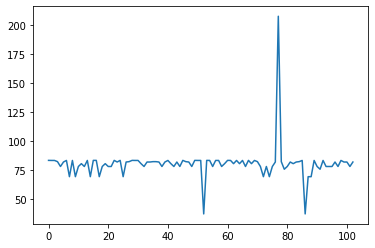

In [ ]:
plt.plot(losses)
plt.show()

### Простая вероятностная стратегия для всех состояний

In [ ]:
import numpy as np
import random

state_n = 42
action_n = 3

table = [1, 1, 1]
# customers = [7, 2, 3]
customers = [7, 2, 3]
costs = [3, 10, 4]

state_n = np.prod(customers)
action_n = len(customers)

class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n
        return None
    
    def get_action(self, state):
        return random.randint(0, self.action_n - 1)
   

In [ ]:
class CEM():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))

    def get_max_action(self, state):
        return max(enumerate(self.policy[state]),key=lambda x: x[1])[0]
        # return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))    
    
    def softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) 
    
    def update_policy(self, elite_trajectories, lr):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
                
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                # print('-----')
                # print(self.policy)
                # print(pre_policy[state] / sum(pre_policy[state]))
                self.policy[state] += pre_policy[state] * lr #/ sum(pre_policy[state])
                self.policy[state] = self.softmax(self.policy[state])
                # self.policy[state] /= sum(self.policy[state])
                # print(self.policy)
        return None

In [ ]:
# table = [1, 1, 1]
# # customers = [7, 2, 3]
# customers = [3, 7, 5]
# costs = [3, 10, 4]

In [ ]:
# def get_state(obs):
#     return int(obs[1] * np.sqrt(state_n) + obs[0])

def get_state(obs):  # Этот функция у нас не работает корректно, добавить в параметры states
    str_obs = [str(x) for x in obs]
    state = int(''.join(str_obs))
    return int(state)
    # return states['state'].index(obs)


def step(obs, action):
    done = False
    obs[action] += 1
    reward = np.sum(np.array(obs) * np.array(costs))
    if obs[0] > customers[0] or obs[1] > customers[1] or obs[2] > customers[2]: # Добавил
        done = True
    if np.sum(obs) > 12: # Заменил на >
        done = True
    return obs, reward, done

def reset():
    start_table = [1, 1, 1]
    return start_table

def get_trajectory(agent, table, trajectory_len, states, idx):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}

    obs = [1, 1, 1]
    state = 0
    trajectory['states'].append(state)
    
    # states['id'].append(idx)
    # states['state'].append(obs.copy())

    for _ in range(trajectory_len):
        # print('Проверка: ', obs, ' in ', states['state'])      

        if obs in states['state'].copy():
            state = states['state'].index(obs)
  ##          print(state, end=' ')
            # print('((((((', idx, states['id'], states['state'],  obs)

        else:
            idx += 1
            states['id'].append(idx) # Не заходит сюда
            states['state'].append(obs.copy())
            state = idx # Добавил
            # print( ')))))))))', idx, states['id'], states['state'])
    ##        print(state, end=' ')



        action = agent.get_action(state)
        state = states['state'].index(obs.copy()) # добавил
        trajectory['actions'].append(action)
        next_obs, reward, done = step(obs, action)

        # state = get_state(next_obs) # убрал
        
        if done:
            print('Я закончил: ', obs, trajectory['total_reward'], trajectory)
            break
        trajectory['total_reward'] += reward
        obs = next_obs
        trajectory['states'].append(state)
        # print(state, next_obs, '!!!')
  ##      print(trajectory, end = ' :-) \n')

    # print(states, 'tut problema')
    # print(states['state'])

    # print('Количество состояний', len(states['state']))
    return trajectory


In [ ]:
state = states['state'].index([1,1,1])
state

1

In [ ]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [ ]:
agent = CEM(state_n, action_n)
episode_n = 500
trajectory_n = 50
trajectory_len = 20
q_param = 0.80
lr = 1.5

states = {'id' : [], 'state': [[1, 1, 1]]}
idx = 0

for _ in range(episode_n):
    trajectories = [get_trajectory(agent, table, trajectory_len, states, idx) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories, lr)


Выходные данные были обрезаны до нескольких последних строк (5000).
Я закончил:  [7, 3, 3] 306 {'states': [0, 0, 17, 24, 13, 14, 15, 16, 31, 33], 'actions': [0, 0, 2, 0, 0, 2, 0, 0, 1, 1], 'total_reward': 306}
220.98
Я закончил:  [8, 1, 2] 206 {'states': [0, 0, 17, 24, 25, 32, 15, 26], 'actions': [0, 0, 0, 0, 2, 0, 0, 0], 'total_reward': 206}
Я закончил:  [6, 3, 2] 225 {'states': [0, 0, 17, 24, 25, 32, 35, 37], 'actions': [0, 0, 0, 0, 1, 0, 2, 1], 'total_reward': 225}
Я закончил:  [7, 3, 3] 302 {'states': [0, 0, 17, 24, 25, 32, 15, 26, 40, 33], 'actions': [0, 0, 0, 0, 2, 0, 0, 2, 1, 1], 'total_reward': 302}
Я закончил:  [6, 2, 4] 256 {'states': [0, 0, 17, 24, 25, 32, 36, 26, 31], 'actions': [0, 0, 0, 0, 0, 2, 2, 1, 2], 'total_reward': 256}
Я закончил:  [6, 2, 4] 257 {'states': [0, 0, 17, 24, 25, 32, 15, 26, 31], 'actions': [0, 0, 0, 0, 2, 0, 2, 1, 2], 'total_reward': 257}
Я закончил:  [6, 3, 2] 225 {'states': [0, 0, 17, 24, 25, 32, 35, 37], 'actions': [0, 0, 0, 0, 1, 0, 2, 1], 'total_r

In [ ]:
# print(len(states['state']), '\n', agent.policy.round(2))
print(costs)
for i in range(len(states['state'])):
    print(states['state'][i], agent.policy[i].round(2), max(enumerate(agent.policy[i]),key=lambda x: x[1])[0])



[3, 10, 4]
[1, 1, 1] [1. 0. 0.] 0
[1, 2, 1] [0.33 0.33 0.33] 0
[2, 2, 1] [0.33 0.33 0.33] 0
[2, 2, 2] [0.88 0.04 0.08] 0
[2, 2, 3] [0.95 0.03 0.03] 0
[3, 2, 3] [0.96 0.02 0.02] 0
[4, 2, 3] [0.03 0.96 0.01] 1
[1, 1, 2] [0.94 0.01 0.05] 0
[1, 1, 3] [0.33 0.33 0.33] 0
[1, 2, 3] [0.69 0.15 0.15] 0
[3, 2, 2] [0.58 0.08 0.34] 0
[1, 2, 2] [0.79 0.04 0.18] 0
[2, 1, 2] [0.86 0.07 0.07] 0
[3, 1, 2] [0.99 0.   0.  ] 0
[4, 1, 2] [0. 1. 0.] 1
[5, 1, 2] [1. 0. 0.] 0
[5, 1, 3] [0.33 0.33 0.33] 0
[2, 1, 1] [0.91 0.02 0.07] 0
[3, 2, 1] [0.69 0.15 0.15] 0
[4, 2, 2] [0.91 0.05 0.05] 0
[2, 1, 3] [0.33 0.33 0.33] 0
[3, 1, 3] [0.33 0.33 0.33] 0
[4, 1, 3] [0.33 0.33 0.33] 0
[5, 2, 3] [0.57 0.3  0.13] 0
[3, 1, 1] [0.05 0.   0.95] 2
[4, 1, 1] [0.98 0.01 0.01] 0
[6, 1, 2] [0.33 0.33 0.33] 0
[6, 2, 2] [0.   0.02 0.98] 2
[6, 2, 3] [0.69 0.15 0.15] 0
[7, 2, 3] [0.33 0.33 0.33] 0
[5, 2, 2] [0. 0. 1.] 2
[6, 1, 3] [0.33 0.33 0.33] 0
[5, 1, 1] [0.33 0.33 0.33] 0
[7, 1, 3] [0.33 0.33 0.33] 0
[4, 2, 1] [0.33 0.33 0.33] 

In [ ]:
print(costs, '<- costs')
print(customers, ' <- limits')

state = 0
obs = [1, 1, 1]
sum_reward = 0
done = False
while not done:
    print(obs, sum_reward)
    state = states['state'].index(obs.copy())
    action = agent.get_max_action(state)
    # print(state, action)
    next_obs, reward, done = step(obs, action)
    obs = next_obs
    sum_reward += reward


[3, 10, 4] <- costs
[7, 2, 3]  <- limits
[1, 1, 1] 0
[2, 1, 1] 20
[3, 1, 1] 43
[3, 1, 2] 70
[4, 1, 2] 100
[4, 2, 2] 140
[5, 2, 2] 183
[5, 2, 3] 230
[6, 2, 3] 280
[7, 2, 3] 333


#Осталось только дублировать логику на нескольких раздельных поставщиков.

In [ ]:
int(a[1] * 2 + a[0])

2

In [ ]:
from traitlets.traitlets import observe
obs = reset()
state = get_state(obs)
print('Начальное состояние:', obs)
while True:
    action = agent.get_action(state)
    next_obs, reward, done = step(obs, action)
    state = get_state(next_obs)
    print('Следующее состояние', next_obs)
    for i in range(len(obs)):
      if obs[i] >= customers[i] or np.sum(obs) >= 40:
        print(obs[i], 'vs', customers[i], 'limit', np.sum(obs))
        continue
    if reward >= 260:
      print(reward)
      print(obs)
      break

    obs = next_obs

Начальное состояние: [0 0]


ValueError: ignored

In [ ]:
customers

[10, 20, 15, 5]

In [ ]:
print(obs)

[2, 3, 22, 3]


In [ ]:
!pip install git+https://github.com/cair/gym-maze.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cair/gym-maze.git to /tmp/pip-req-build-qehhz6ti
  Running command git clone --filter=blob:none --quiet https://github.com/cair/gym-maze.git /tmp/pip-req-build-qehhz6ti
  Resolved https://github.com/cair/gym-maze.git to commit a6e1f01e1712fe5279f4b87f309269830864f8c2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 43.0 MB/s eta 0:00:00
  Created wheel for gym-maze: filename=gym_maze-2.0.0-py3-none-any.whl size=11323 sha256=9263ae047c7867f90f4cab9d5b617b730381d566208086ab34f6fb4e0022a022
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2bwx9x0/wheels/6c/e0/cc/1a724ccbe7abd1d3297b552dace796d10b812e7ee9edda3489
Successfully built gym-maze


In [ ]:
import gym
import gym_maze
import numpy as np
import random
import time

env = gym.make('Maze-5x5-POMDPMaze')
state_n = 25
action_n = 4


class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n
        return None
    
    def get_action(self, state):
        return random.randint(0, self.action_n - 1)

class CEM():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))
    
    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
                
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
                
        return None
                

def get_state(obs):
    return int(obs[1] * np.sqrt(state_n) + obs[0])

def get_trajectory(agent, trajectory_len):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    obs = env.reset()
    state = get_state(obs)
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        obs, reward, done, _ = env.step(action)
        state = get_state(obs)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        trajectory['states'].append(state)
            
    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]


agent = CEM(state_n, action_n)
episode_n = 50
trajectory_n = 100
trajectory_len = 100
q_param = 0.9


for _ in range(episode_n):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(mean_total_reward)
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

#test
obs = env.reset()
state = get_state(obs)

for _ in range(trajectory_len):

    action = agent.get_action(state)

    obs, reward, done, _ = env.step(action)
    state = get_state(obs)
    
    #env.render()
    time.sleep(0.5)

    if done:
        break

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `Maze-5x5-POMDPMaze-v0` instead of the unversioned environment `Maze-5x5-POMDPMaze`.
  logger.warn(


AssertionError: ignored